In [4]:
# Install PyTorch and related packages
%pip install torch torchvision torchaudio

# Install numpy, pandas, matplotlib, and scikit-learn
%pip install numpy pandas matplotlib scikit-learn

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------- ------------------------------- 0.2/1.2 MB 7.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.2 MB 5.9 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.2 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   --------- ------------------------------ 0.6/2.4 MB 11.5 MB/s eta 0:00:01
   --------------------- ------------------ 1.3/2.4 MB 13.7 MB/s eta 0:00:01
   ------------------------------ --------- 1.8/2.4 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -------------------------------------- 162.8/162.8 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.7 MB 15.9 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.7 MB 22.3 MB/s eta 0:00:01
   ---------- ----------------------------- 2.0/7.7 MB 18.4 MB/s eta 0:00:01
   -------------- ------------------------- 2.7/7.7 MB 17.3 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.7 MB 15.4 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.7 MB 15.1 MB/s eta 0:00:01
   ---------------------- ----------------- 4.2/7.7 MB 14.2 MB/s eta 0:00:01
   ------------------------ --------------- 4.7/7.7 MB 13.6 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data
file_path = "./static_data_summary.csv"
data = pd.read_csv(file_path)

# Extract the 'totpop' column
totpop = data['totpop'].values

# Convert 'totpop' to a tensor and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
populations = torch.tensor(totpop, dtype=torch.float32).to(device)

# data.head()

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [4]:
# Extract features and target from the data
features = data[['SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'pctmale', 
                 'pctbachelor', 'young2', 'pcthisp', 'carown', 'pctlowinc', 'pctmidinc', 'pcthighinc', 
                 'pctsinfam2', 'CrimeDen', 'RdNetwkDen', 'InterstDen']].values
totpop = data['totpop'].values  #totpop is the target variable used for creating the monotonicity constraint
# Monotonicty Constraint: as totpop increases, travel demand should increase 
# Predict 'travel_demand', use random values for now
np.random.seed(0)
travel_demand = np.random.rand(len(features)) * 1000  # Replace with actual travel demand data if available

# Convert to tensors
X_train = torch.tensor(features, dtype=torch.float32).to(device)
y_train = torch.tensor(travel_demand, dtype=torch.float32).to(device).view(-1, 1)
populations = torch.tensor(totpop, dtype=torch.float32).to(device)

# Normalize target for training
mean_value = y_train.mean()
std_value = y_train.std()
y_train = (y_train - mean_value) / std_value

In [5]:
# Computes a penalty if the predictions do not uphold monotonic constraint 
def calculate_monotonicity_penalty(preds, populations, device):
    penalty = torch.zeros(1, device=device)
    for i in range(1, len(preds)):
        if populations[i] > populations[i - 1] and preds[i] < preds[i - 1]:
            penalty += torch.abs(preds[i] - preds[i - 1])
    return penalty

In [6]:
# Combines MSE loss w the monotonicity penalty, weighted by lambda 
def calculate_loss(y_pred, label, std_value, mean_value, cost1_func, lam, device, populations):
    y_pred_trans = y_pred * std_value + mean_value
    label_trans = label * std_value + mean_value + 1

    cost1 = cost1_func(y_pred, label).double()

    # Monotonicity penalty
    monotonicity_penalty = calculate_monotonicity_penalty(y_pred_trans, populations, device)

    # total loss equation
    cost = (1 - lam) * cost1 + lam * monotonicity_penalty
    return cost, cost1, monotonicity_penalty, y_pred_trans

In [9]:
# Define model, criterion, and optimizer
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lam = 0.5  # Lambda for the monotonicity penalty

# Training loop
# In each epoch, the model performs a forward pass, calculates the loss, computes gradients, and updates the parameters.
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(X_train)
    
    # Calculate loss
    loss, cost1, monotonicity_penalty, y_pred_trans = calculate_loss(
        y_pred, y_train, std_value, mean_value, criterion, lam, device, populations
    )
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss for monitoring
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Cost1: {cost1.item()}, Monotonicity Penalty: {monotonicity_penalty.item()}')

print("Training completed")

Epoch [1/100], Loss: 10087300.0, Cost1: 1884285.5, Monotonicity Penalty: 18290314.0
Epoch [2/100], Loss: 9142963.0, Cost1: 1589691.75, Monotonicity Penalty: 16696234.0
Epoch [3/100], Loss: 8215108.0, Cost1: 1320659.625, Monotonicity Penalty: 15109556.0
Epoch [4/100], Loss: 7303833.5, Cost1: 1076952.625, Monotonicity Penalty: 13530714.0
Epoch [5/100], Loss: 6406249.0, Cost1: 858568.9375, Monotonicity Penalty: 11953929.0
Epoch [6/100], Loss: 5524241.5, Cost1: 665398.9375, Monotonicity Penalty: 10383084.0
Epoch [7/100], Loss: 4662938.5, Cost1: 497336.03125, Monotonicity Penalty: 8828541.0
Epoch [8/100], Loss: 3820111.5, Cost1: 354263.0625, Monotonicity Penalty: 7285960.0
Epoch [9/100], Loss: 3004571.75, Cost1: 235920.359375, Monotonicity Penalty: 5773223.0
Epoch [10/100], Loss: 2229675.5, Cost1: 142030.46875, Monotonicity Penalty: 4317320.5
Epoch [11/100], Loss: 1508373.375, Cost1: 72341.6171875, Monotonicity Penalty: 2944405.25
Epoch [12/100], Loss: 920636.875, Cost1: 26787.3203125, Mono

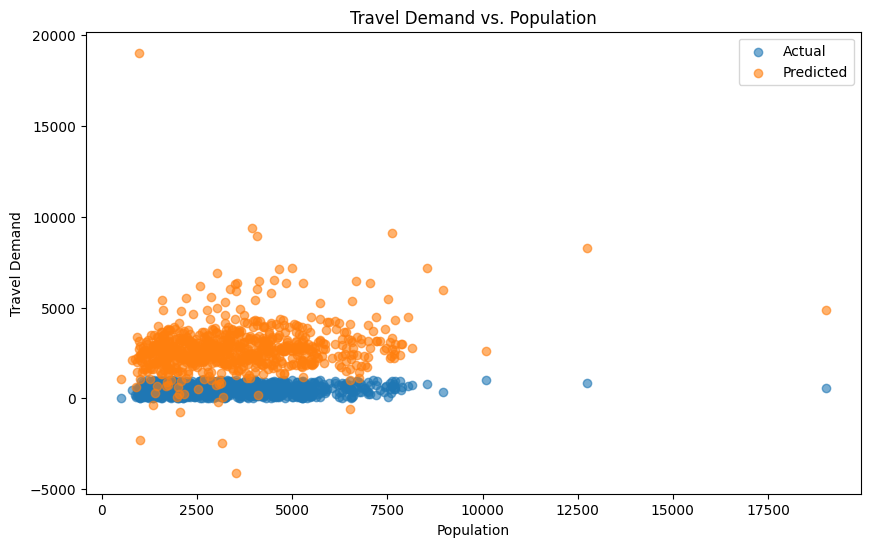

In [10]:
# Assuming y_pred is the final predictions tensor and y_train is the actual tensor
y_pred_final = model(X_train).detach().cpu().numpy() * std_value.item() + mean_value.item()
y_train_final = y_train.cpu().numpy() * std_value.item() + mean_value.item()
populations_final = populations.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(populations_final, y_train_final, label='Actual', alpha=0.6)
plt.scatter(populations_final, y_pred_final, label='Predicted', alpha=0.6)
plt.xlabel('Population')
plt.ylabel('Travel Demand')
plt.title('Travel Demand vs. Population')
plt.legend()
plt.show()